In [1]:
%matplotlib inline

import louvain
import igraph as ig
from igraph.drawing import plot

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import normalized_mutual_info_score

In [2]:
# G = ig.Graph.Read_Ncol("Uetz_screen.txt", directed=False)
G = ig.Graph.Read_GML("embedded_karate.gml")
G = G.clusters(mode="weak").giant()

In [3]:
resolutions = np.arange(0.25, 4.25, 0.25)

In [4]:
parts = [louvain.find_partition(G, method="RBConfiguration", resolution_parameter=r) for r in resolutions]

In [5]:
modularities = [(r, part.quality) for r, part in zip(resolutions, parts)]

In [6]:
assignments = [(r, max(part.membership)) for r, part in zip(resolutions, parts)]

In [7]:
NMIs = np.array([normalized_mutual_info_score(G.vs["club"], part.membership) for r, part in zip(resolutions, parts)])

In [10]:
NMIs.max()

0.67724304110260169

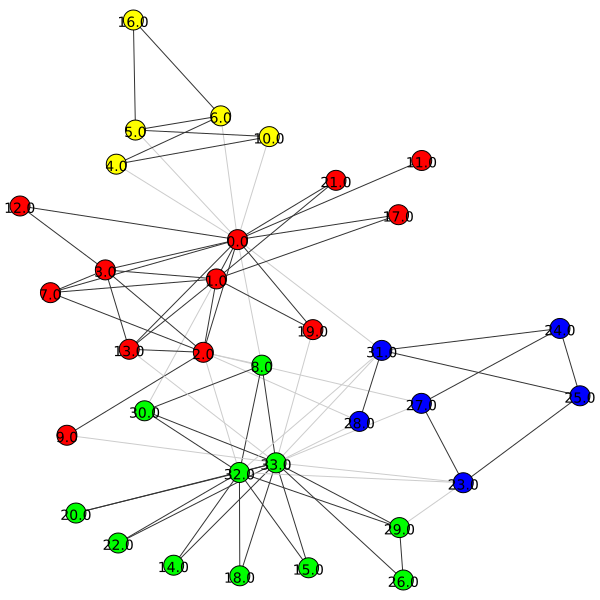

In [19]:
# plot(parts[NMIs.argmax()])
plot(parts[np.where(resolutions==1.0)[0][0]])

In [112]:
membership, quality = louvain.find_partition_multiplex(layers=[
    louvain.Layer(graph=G, method="RBConfiguration", layer_weight=0.1, resolution_parameter=r) for r in resolutions
])

In [10]:
res_parts = louvain.bisect(G, method='RBConfiguration', resolution_range=[0,10])

In [16]:
plot(res_parts.values()[0])

TypeError: not all arguments converted during string formatting

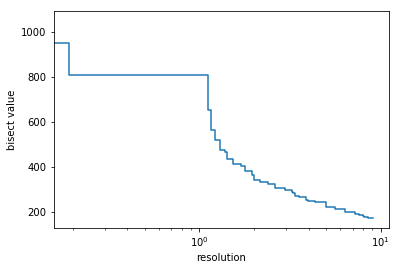

In [11]:
res_df = pd.DataFrame({
         'resolution': res_parts.keys(),
         'bisect_value': [bisect.bisect_value for bisect in res_parts.values()]});
plt.step(res_df['resolution'], res_df['bisect_value']);
plt.xscale('log');
plt.xlabel("resolution")
plt.ylabel("bisect value")

In [30]:
#%%
# number of nodes in G
n = len(G.vs)

# number of slices
D = len(resolutions)

# initialise slices
slices = [G for l in range(D)]

# initialise ids
for H in slices:
    H.vs['id'] = np.arange(n)

# initialise edge data frame for each slice
E = [pd.DataFrame(H.get_edgelist(), columns=['source', 'target']) for H in slices]
 
# Set time for edges
for t in range(D):
    E[t]['t'] = t + 1

# Concatenate
E = pd.concat(E)

# Make sure that the id's are different for different slices
E['source'] = ['{0}-{1}'.format(row['source'],row['t']) for idx, row in E.iterrows()]
E['target'] = ['{0}-{1}'.format(row['target'],row['t']) for idx, row in E.iterrows()]
 
# Add weight
E['weight'] = 1.0;
 
#%%
# Add interslice links (to adjacent layers)
w = 0.0;
for i in range(D - 1):
    for v in slices[i].vs:
        for u in slices[i + 1].vs:
            if v['id'] == u['id']:
                source = '{0}-{1}'.format(v.index, i + 1)
                target = '{0}-{1}'.format(u.index, i + 2)
                E = E.append([{'source': source, 'target': target, 'weight': w, 't': 'interslice'}])
                
def GraphFromPandasEdgeList(edges_df, edge_cols = ['source', 'target'], **kwargs):
 
    def renumber_edges(edges, ids):
        for e in edges:
            if not e[0] in ids:
                raise Exception('Couldn\'t find {0} in nodes dataframe'.format(e[0]));
            e0 = ids[e[0]];
            e1 = ids[e[1]];
            yield (e0, e1);
 
    # Renumber nodes
    node_id = ig.UniqueIdGenerator();
    nodes = edges_df[edge_cols].stack().unique();
    for node in nodes:
        node_id.add(node);
 
    # Create graph
    G = ig.Graph(**kwargs);
    G.add_vertices(len(nodes));
    G.vs['id'] = node_id.values();

    # Renumber edges so that they are consistent
    # with the node numbering.
    edges = renumber_edges(
               edges_df[edge_cols].itertuples(index=False), 
               node_id);
    G.add_edges(edges);

    for k, v in edges_df.iteritems():
        if not k in edge_cols:
            G.es[k] = list(v);

    return G;

# create cmulti slice graph
H = GraphFromPandasEdgeList(E, directed=False)

# subgraphs for each layer
subgraphs = [H.subgraph_edges(H.es.select(t_eq = i + 1), delete_vertices=False) for i in range(D)]

# interslice subgraph
H_interslice = H.subgraph_edges(H.es.select(t_eq = 'interslice'), delete_vertices=False)

# multiplex louvain
membership, quality = louvain.find_partition_multiplex(
    layers = [louvain.Layer(subgraphs[i], "RBConfiguration", resolution_parameter=resolutions[i]) for i in range(D)]
    + [louvain.Layer(H_interslice, 'CPM', resolution_parameter=0)]
   )

In [35]:
for S in subgraphs:
    
    for v in S.vs:
        print v
        
    print

igraph.Vertex(<igraph.Graph object at 0x7fecd2caa430>,0,{'id': '0-1'})
igraph.Vertex(<igraph.Graph object at 0x7fecd2caa430>,1,{'id': '1-1'})
igraph.Vertex(<igraph.Graph object at 0x7fecd2caa430>,2,{'id': '2-1'})
igraph.Vertex(<igraph.Graph object at 0x7fecd2caa430>,3,{'id': '3-1'})
igraph.Vertex(<igraph.Graph object at 0x7fecd2caa430>,4,{'id': '4-1'})
igraph.Vertex(<igraph.Graph object at 0x7fecd2caa430>,5,{'id': '5-1'})
igraph.Vertex(<igraph.Graph object at 0x7fecd2caa430>,6,{'id': '6-1'})
igraph.Vertex(<igraph.Graph object at 0x7fecd2caa430>,7,{'id': '7-1'})
igraph.Vertex(<igraph.Graph object at 0x7fecd2caa430>,8,{'id': '8-1'})
igraph.Vertex(<igraph.Graph object at 0x7fecd2caa430>,9,{'id': '10-1'})
igraph.Vertex(<igraph.Graph object at 0x7fecd2caa430>,10,{'id': '11-1'})
igraph.Vertex(<igraph.Graph object at 0x7fecd2caa430>,11,{'id': '12-1'})
igraph.Vertex(<igraph.Graph object at 0x7fecd2caa430>,12,{'id': '13-1'})
igraph.Vertex(<igraph.Graph object at 0x7fecd2caa430>,13,{'id': '17-1'

In [28]:
?louvain.find_partition_multiplex

In [21]:
len(G.vs)

34

In [22]:
len(subgraphs[0].vs)

544

In [31]:
membership = np.array(membership).reshape(-1,D)

In [32]:
membership.shape

(34, 16)

In [33]:
np.max(membership, axis=0)

array([137, 136, 114, 135, 127, 120, 129, 122, 116, 131, 118, 130, 110,
       125, 133, 134])

In [34]:
membership

array([[  0,   0,   7,  10,  14,   0,  81,  82,  83,  45,  84,  85,   1,
          0,  86,  10],
       [ 87,   1,   7,   1,   1,   1,  46,   1,   1,  62,   1,  88,  89,
          7,  44,   7],
       [ 61,   1,  10,  90,   1,  10,  14,  14,  14,   1,   7,  45,  80,
         10,   1,   0],
       [  1,  10,  61,  91,   7,  92,   1,   1,  46,   1,   1,  62,   1,
          1,   1,  93],
       [ 44,   7,  44,   1,   0,   0,   7,  10,  63,  14,  63,  10,   0,
         45,   0,  10],
       [  1,   0,   1,  94,   1,   1,   7,   1,   8,   0,  46,   1,   1,
          1,   7,   1],
       [  1,   8,   8,   7,   8,   4,   0,  64,   0,  10,  95,  14,   0,
          0,   0,   0],
       [  0,  96,  97,   0,  64,   0,   8,   1,   4,   0,   1,   0,  14,
          1,   1,   4],
       [  7,  98,   1,   4,  99,   4,   8,   4,   0,   0,  29,   0,   0,
         14,   0,  29],
       [ 65,  14,   0,   0,   0,   0,   0, 100,   8,  65,   4, 101,   1,
         15,   0,  47],
       [  4,   2,   4,  47,   

In [36]:
G.vs["club"]

['Mr. Hi',
 'Mr. Hi',
 'Mr. Hi',
 'Mr. Hi',
 'Mr. Hi',
 'Mr. Hi',
 'Mr. Hi',
 'Mr. Hi',
 'Mr. Hi',
 'Officer',
 'Mr. Hi',
 'Mr. Hi',
 'Mr. Hi',
 'Mr. Hi',
 'Officer',
 'Officer',
 'Mr. Hi',
 'Mr. Hi',
 'Officer',
 'Mr. Hi',
 'Officer',
 'Mr. Hi',
 'Officer',
 'Officer',
 'Officer',
 'Officer',
 'Officer',
 'Officer',
 'Officer',
 'Officer',
 'Officer',
 'Officer',
 'Officer',
 'Officer']